In [1]:
import numpy as np
import torch

from tqdm import tqdm
from matplotlib import pyplot as plt

import seaborn as sns

%load_ext autoreload
%autoreload 2


Bad key savefig.frameon in file /home/yuling/miniconda3/envs/gridRNN/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle, line 421 ('savefig.frameon : True')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.3.4/matplotlibrc.template
or from the matplotlib source distribution

Bad key verbose.level in file /home/yuling/miniconda3/envs/gridRNN/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle, line 472 ('verbose.level  : silent      # one of silent, helpful, debug, debug-annoying')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.3.4/matplotlibrc.template
or from the matplotlib source distribution

Bad key verbose.fileo in file /home/yuling/miniconda3/envs/gridRNN/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle, line 473 ('verbose.fileo  : sys.stdout  # a log filename, sys.stdout or

In [2]:
# If GPUs available, select which to train on
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="0"

In [3]:
from utils import generate_run_ID, load_trained_weights
from place_cells import PlaceCells
from trajectory_generator import TrajectoryGenerator
from model import RNN
from trainer import Trainer

# model prepare

In [4]:
# Training options and hyperparameters
class Options:
    pass
options = Options()

options.save_dir = '/home/yuling/grid-pattern-formation/models'
options.n_steps = 100000      # number of training steps
options.batch_size = 200      # number of trajectories per batch
options.sequence_length = 20  # number of steps in trajectory
options.learning_rate = 1e-4  # gradient descent learning rate
options.Np = 512              # number of place cells
options.Ng = 4096             # number of grid cells
options.place_cell_rf = 0.12  # width of place cell center tuning curve (m)
options.surround_scale = 2    # if DoG, ratio of sigma2^2 to sigma1^2
options.RNN_type = 'RNN'      # RNN or LSTM
options.activation = 'relu'   # recurrent nonlinearity
options.weight_decay = 1e-4   # strength of weight decay on recurrent weights
options.DoG = True            # use difference of gaussians tuning curves # ?
options.periodic = False      # trajectories with periodic boundary conditions
options.box_width = 2.2       # width of training environment
options.box_height = 2.2      # height of training environment

options.run_ID = generate_run_ID(options)
options.device = 'cpu'

In [5]:
# If you've trained with these params before, will restore trained model
place_cells = PlaceCells(options)
model = RNN(options, place_cells) #.cuda()
trajectory_generator = TrajectoryGenerator(options, place_cells)
trainer = Trainer(options, model, trajectory_generator)

Initializing new model from scratch.
Saving to: /home/yuling/grid-pattern-formation/models/steps_20_batch_200_RNN_4096_relu_rf_012_DoG_True_periodic_False_lr_00001_weight_decay_00001


In [6]:
# Load example weights stored on github
weight_dir = options.save_dir + '/example_trained_weights.npy'
load_trained_weights(model, trainer, weight_dir)

Epoch: 0/1. Step 0/1. Loss: 6.37. Err: 99.14cm
Loaded trained weights.


# data prepare

In [7]:
band_score = np.load('./data/band_score.npy')
grid_score = np.load('./data/grid_score.npy')

In [8]:
# from prune_rnn import Pruner

# band_idx = np.where(band_score > 8.0)[0]
# grid_idx = np.where(np.asarray(grid_score) > 1.2)[0]
# combined_idx = np.concatenate((band_idx, grid_idx))
# random_idx = np.arange(0, 4096)
# n_steps=1
# mask_size=150

# band_err = Pruner(model, trajectory_generator).prun(mask=band_idx, n_steps=n_steps, mask_size=mask_size)
# grid_err = Pruner(model, trajectory_generator).prun(mask=grid_idx, n_steps=n_steps, mask_size=mask_size)
# rand_err = Pruner(model, trajectory_generator).prun(mask = random_idx, n_steps=n_steps, mask_size=mask_size)

In [9]:
band_err = np.load('./data/band_err_1.npy')
grid_err = np.load('./data/grid_err.npy')
rand_err = np.load('./data/rand_err_1.npy')

# plot

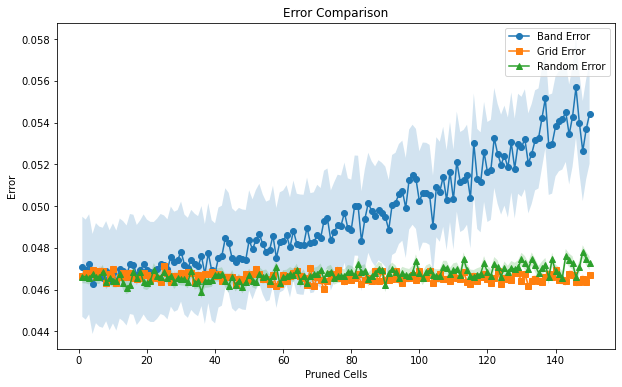

In [11]:
# 创建一个 x 轴的范围
x = range(1, 151)

# 计算误差的标准差
band_err_std = np.std(band_err)
grid_err_std = np.std(grid_err)
rand_err_std = np.std(rand_err)

# 绘制折线图
plt.figure(figsize=(10, 6))
plt.plot(x, band_err, label='Band Error', marker='o')
plt.fill_between(x, np.array(band_err) - band_err_std, np.array(band_err) + band_err_std, alpha=0.2)
plt.plot(x, grid_err, label='Grid Error', marker='s')
plt.fill_between(x, np.array(grid_err) - grid_err_std, np.array(grid_err) + grid_err_std, alpha=0.2)
plt.plot(x, rand_err, label='Random Error', marker='^')
plt.fill_between(x, np.array(rand_err) - rand_err_std, np.array(rand_err) + rand_err_std, alpha=0.2)

# 设置图形标题和轴标签
plt.title('Error Comparison')
plt.xlabel('Pruned Cells')
plt.ylabel('Error')

# 添加图例
plt.legend()

# 显示图形
plt.show()